<h1>SVD Implementation </h1>
<h4> Mike Altschwager </h4>
Outlines a base scikit learn pipeline for using the Singular Value Decomposition ratings to determine recommendations for a user. 

Lessons learned:

*

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix
import numpy as np

<h1> Load Data </h1>

In [2]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')

In [3]:
original_movie_ids = set(movies_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
movies_df["movieId"] = movies_df["movieId"].map(movie_id_map)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
original_movie_ids = set(ratings_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
ratings_df["movieId"] = ratings_df["movieId"].map(movie_id_map)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


<h1> Build Raiding Matrix </h1>

In [5]:


# Get the unique user IDs and movie IDs
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()

# Create a dictionary to map movie IDs to column indices
movie_id_map = {movie_id: i for i, movie_id in enumerate(movie_ids)}

In [6]:
len(movie_ids)

59047

In [7]:

# Initialize lists to store the row indices, column indices, and ratings
row_indices = []
col_indices = []
ratings = []

# Iterate over the ratings dataframe
for _, row in ratings_df.iterrows():
    row_indices.append(int(row['userId']))
    col_indices.append(int(row['movieId']))
    ratings.append(row['rating'])

In [8]:
# Create the sparse spatial matrix
sparse_matrix = csr_matrix((ratings, (row_indices, col_indices)))
sparse_matrix.shape

(162542, 59047)

<h1> Test Train Split</h1>

In [9]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(sparse_matrix, test_size=0.2, train_size=0.8)

Split Test Ratings per User into 80/20% split. We're doing this above the actual training logic so this doesn't have to recompute every time that logic is updated

In [10]:
import numpy as np

# Initialize empty lists to store the row indices, column indices, and values
row_indices_80 = []
col_indices_80 = []
values_80 = []

row_indices_20 = []
col_indices_20 = []
values_20 = []

# Iterate over each row in test_dataset
for row_idx in range(test_dataset.shape[0]):
    # Get the non-zero indices and values for the current row
    non_zero_indices = test_dataset[row_idx].nonzero()[1]
    non_zero_values = test_dataset[row_idx].data
    
    # Calculate the number of non-zero values to include in the 80% matrix
    num_values_80 = int(len(non_zero_values) * 0.8)
    
    # Split the non-zero indices and values into 80% and 20% portions
    indices_80 = np.random.choice(non_zero_indices, size=num_values_80, replace=False)
    indices_20 = np.setdiff1d(non_zero_indices, indices_80)
    
    values_80.extend(non_zero_values[np.isin(non_zero_indices, indices_80)])
    values_20.extend(non_zero_values[np.isin(non_zero_indices, indices_20)])
    
    row_indices_80.extend([row_idx] * len(indices_80))
    row_indices_20.extend([row_idx] * len(indices_20))
    
    col_indices_80.extend(indices_80)
    col_indices_20.extend(indices_20)

# Create the 80% and 20% csc_matrix objects
input_ratings = csr_matrix((values_80, (row_indices_80, col_indices_80)))
test_ratings = csr_matrix((values_20, (row_indices_20, col_indices_20)))

#Need to resize the input_ratings and test_ratings to match the shape of the original test_dataset to fix the columns dropped for having no avg rating (due to no ratings existing period)
input_ratings.resize(test_dataset.shape)
test_ratings.resize(test_dataset.shape)


<h1> Define training function </h1>

In [17]:
from scipy import sparse
from sklearn.base import BaseEstimator
from sklearn.decomposition import TruncatedSVD

class SVDRatingModel(BaseEstimator): 
    def __init__(self, k: int):
        self.model = TruncatedSVD(n_components = k)
        
    def fit(self, training_ratings_matrix: csr_matrix):
        self.training_ratings_matrix = training_ratings_matrix # Store the training ratings matrix so we can grab the nearest neighbors later
        self.model.fit(self.training_ratings_matrix)
        
    def predict(self, user_ratings_matrix: csr_matrix):  
        transformed = self.model.transform(user_ratings_matrix)
        result = self.model.inverse_transform(transformed)
        result[np.isclose(result, 0)] = 0
        
        return csr_matrix(result)

<h1>Define Eval Functions </h1>

In [18]:
#load the ratings back into an array in order to compare them
def compare_ratings(predictions: csr_matrix, predictions_array, test_ratings: csr_matrix, test_ratings_array):
    non_zero_indices = test_ratings.nonzero()

    test_ratings_array.extend(test_ratings[non_zero_indices[0], non_zero_indices[1]])
    predictions_array.extend(predictions[non_zero_indices[0], non_zero_indices[1]])
    return test_ratings_array, predictions_array

In [19]:
def compute_predictions(avg_rat_model, input_ratings, test_ratings):
    test_ratings_array = []
    predictions_array = []
    batch_size = 1000

    for i in range(0, input_ratings.shape[0], batch_size):
        batch_input_og = input_ratings[i:i+batch_size]
        batch_predictions = avg_rat_model.predict(batch_input_og)
        test_ratings_array, predictions_array = compare_ratings(batch_predictions, predictions_array, test_ratings[i:i+batch_size], test_ratings_array)
        #break #this is just to short circuit the loop for testing purposes

    # Replace NaNs that came from dividing by 0 in the fit with 0s, probabbly could do this further up stream, but figured this made the predict loop faster
    predictions_array = np.nan_to_num(predictions_array[0].A1)
    return predictions_array, test_ratings_array[0].A1



In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

def show_box_plot(test_ratings_array, predictions_array):
    # Create a new array to store the rounded predictions
    rounded_predictions_array = np.round(predictions_array * 2) / 2

    # Combine the test_ratings_array and rounded_predictions_array into a DataFrame
    data = pd.DataFrame({'Test Ratings': test_ratings_array, 'Predictions': rounded_predictions_array})

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create a boxplot using seaborn
    sns.boxplot(data=data, x='Test Ratings', y='Predictions', ax=ax)

    # Set the labels for x-axis and y-axis
    ax.set_xlabel('Test Ratings')
    ax.set_ylabel('Predictions')

    # Set the title of the plot
    ax.set_title('Boxplot of Test Ratings vs Predictions')

    # Show the plot
    plt.show()

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def print_stats(test_ratings_array, predictions_array):

    #Root mean-squared error (RMSE)
    rmse = mean_squared_error(test_ratings_array, predictions_array)
    print('rmse: ', rmse)
    #Pearson's Correlation Coefficient (R2)
    r2 = r2_score(test_ratings_array, predictions_array) 
    print('r2: ', r2)
    #Fraction of user-movie pairs with non-zero predicted ratings
    print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(predictions_array)/len(predictions_array))
    #Fraction of user-movie ratings with a predicted values (recall)
    subtracted_array = np.subtract(predictions_array, test_ratings_array) #zeros mean perfect match
    subtracted_array_rounded = np.round(subtracted_array * 2) / 2 #round to nearest 0.5

    print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(subtracted_array_rounded)/len(subtracted_array))
    #RMSE is appropriate if we want to exactly the predict the ratings of the users.  R2 is useful if we don't care about the ranges of the ratings, just that the predicted ratings rank items in a manner consistent with the user-provided ratings.  The MovieLens ratings are in increments of 0.5.  This makes it easy to visualize the relationships between the user-provided and predicted ratings using a boxplot (user-provided ratings on the X axis, predicted ratings on the Y axis).


<h1> Run Trials </h1>

<H2>K=25<h2>

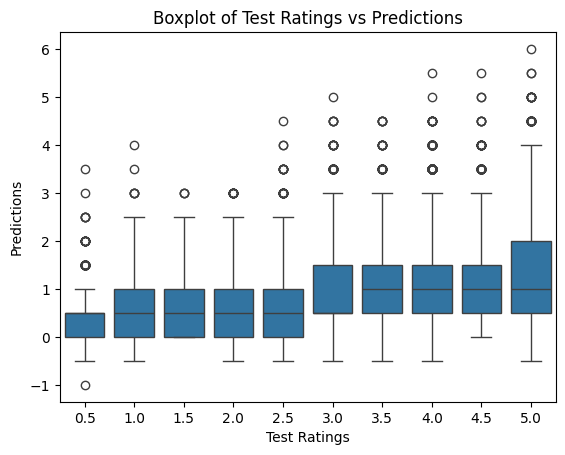

rmse:  7.843678918986586
r2:  -5.642545572434309
Fraction of user-movie pairs with non-zero predicted ratings  0.999814333457111
Fraction of user-movie pairs with non-zero predicted ratings  0.975987127119693


In [22]:
svd_model = SVDRatingModel(25)

svd_model.fit(train_dataset)

predictions_array, test_ratings_array = compute_predictions(svd_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>K=50<h2>

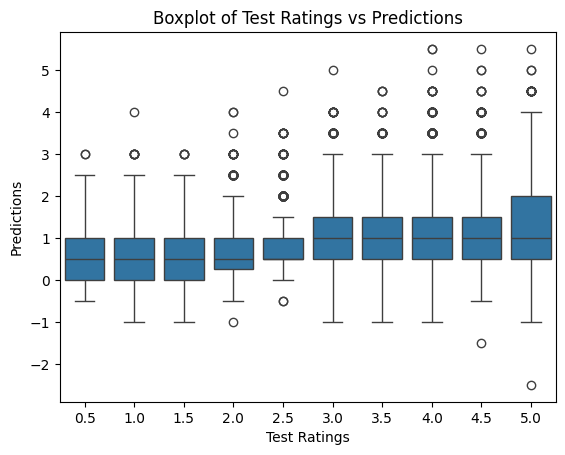

rmse:  7.687403210037208
r2:  -5.510200976322916
Fraction of user-movie pairs with non-zero predicted ratings  0.999814333457111
Fraction of user-movie pairs with non-zero predicted ratings  0.974718405743285


In [23]:
svd_model = SVDRatingModel(50)

svd_model.fit(train_dataset)

predictions_array, test_ratings_array = compute_predictions(svd_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>K=100<h2>

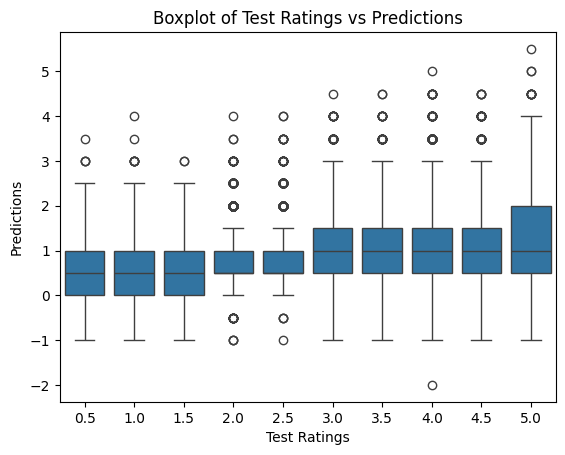

rmse:  7.880328083507888
r2:  -5.673582506510627
Fraction of user-movie pairs with non-zero predicted ratings  0.999814333457111
Fraction of user-movie pairs with non-zero predicted ratings  0.9747802945909148


In [24]:
svd_model = SVDRatingModel(100)

svd_model.fit(train_dataset)

predictions_array, test_ratings_array = compute_predictions(svd_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>K=150<h2>

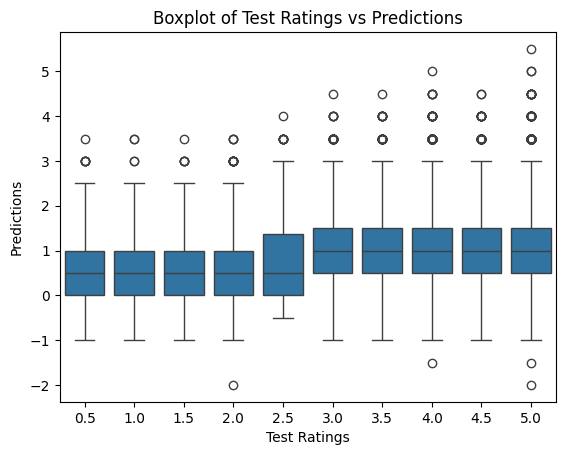

rmse:  8.172883968287895
r2:  -5.921338160102081
Fraction of user-movie pairs with non-zero predicted ratings  0.999814333457111
Fraction of user-movie pairs with non-zero predicted ratings  0.9754920163386558


In [25]:
svd_model = SVDRatingModel(150)

svd_model.fit(train_dataset)

predictions_array, test_ratings_array = compute_predictions(svd_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>K=200<h2>

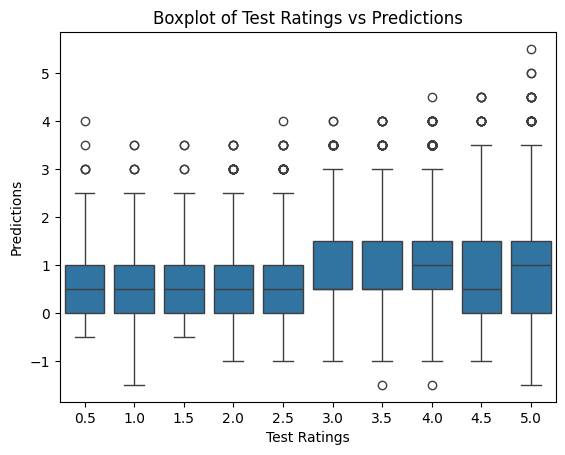

rmse:  8.49174342506817
r2:  -6.191369416447577
Fraction of user-movie pairs with non-zero predicted ratings  0.999814333457111
Fraction of user-movie pairs with non-zero predicted ratings  0.9762037380863968


In [26]:
svd_model = SVDRatingModel(200)

svd_model.fit(train_dataset)

predictions_array, test_ratings_array = compute_predictions(svd_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)